# Linear regression for predicting height from weight

We illustrate priors for linear and polynomial regression using the example in sec 4.4  of [Statistical Rethinking ed 2](https://xcelab.net/rm/statistical-rethinking/). 
The numpyro code is from [Du Phan's site](https://fehiepsi.github.io/rethinking-numpyro/04-geocentric-models.html).


In [20]:

import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
import pandas as pd

import jax
print("jax version {}".format(jax.__version__))
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))

import jax.numpy as jnp
from jax import random

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

try:
    import numpyro
except ModuleNotFoundError:
    %pip install -qq numpyro
    import numpyro


import numpyro.distributions as dist
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify

import seaborn as sns
latexify(3, fig_height = 1.5)

jax version 0.3.13
jax backend cpu


/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


# Data


We use the "Howell" dataset, which consists of measurements of height, weight, age and sex, of a certain foraging tribe, collected by Nancy Howell.

In [21]:
# url = 'https://github.com/fehiepsi/rethinking-numpyro/tree/master/data/Howell1.csv?raw=True'
url = "https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/Howell1.csv"

Howell1 = pd.read_csv(url, sep=";")
d = Howell1
d.info()
d.head()

# get data for adults
d2 = d[d.age >= 18]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


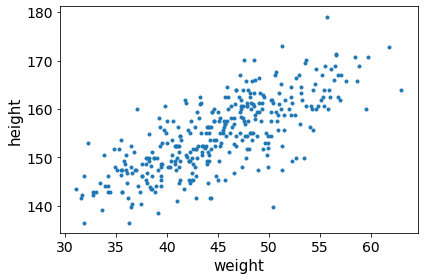

In [22]:
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"))
plt.tight_layout()

# Prior predictive distribution

In [23]:
def plot_prior_predictive_samples(a, b, title, fname=None):
    plt.figure()
    plt.subplot(
        xlim=(d2.weight.min(), d2.weight.max()),
        ylim=(-100, 400),
        xlabel="weight",
        ylabel="height",
    )
    plt.axhline(y=0, c="b", ls="--", label="embryo")
    plt.axhline(y=272, c="r", ls="--", label="tallest man")
    plt.title(r"b $\sim$ " + title)
    xbar = d2.weight.mean()
    x = jnp.linspace(d2.weight.min(), d2.weight.max(), 101)
    for i in range(N):
        plt.plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    plt.tight_layout()
    plt.xticks([45, 60])
    plt.legend(fontsize=7, bbox_to_anchor=(0.3, 0.0), frameon=True)
    sns.despine()
    if fname:
        savefig(fname)

## Gaussian prior

/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


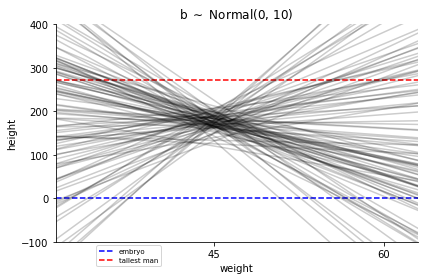

In [24]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a = numpyro.sample("a", dist.Normal(178, 20).expand([N]))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([N]))

plot_prior_predictive_samples(a, b, title="Normal(0, 10)", fname="linreg_height_weight_gauss_prior.pdf")

## Log-Gaussian prior

/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


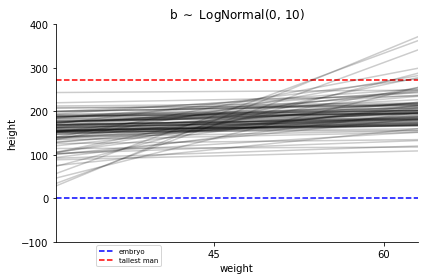

In [25]:
with numpyro.handlers.seed(rng_seed=2971):
    N = 100  # 100 lines
    a1 = numpyro.sample("a1", dist.Normal(178, 28).expand([N]))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1).expand([N]))

plot_prior_predictive_samples(a1, b1, title="LogNormal(0, 10)", fname="linreg_height_weight_loggauss_prior.pdf")

# Posterior

We use the log-gaussian prior.
We compute a Laplace approximation to the posterior.

In [26]:
xbar = d2.weight.mean()


def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


def model2(weight, height=None):  # equivalent version
    a = numpyro.sample("a", dist.Normal(178, 20))
    log_b = numpyro.sample("log_b", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + jnp.exp(log_b) * (weight - xbar))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m4_3, optim.Adam(1), Trace_ELBO(), weight=d2.weight.values, height=d2.height.values)
svi_result = svi.run(random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|██████████| 2000/2000 [00:01<00:00, 1383.99it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297]


In [27]:
post = m4_3.sample_posterior(random.PRNGKey(1), p4_3, (1000,))
{latent: list(post[latent].reshape(-1)[:5]) for latent in post}

{'a': [DeviceArray(154.366, dtype=float32),
  DeviceArray(154.785, dtype=float32),
  DeviceArray(154.735, dtype=float32),
  DeviceArray(154.538, dtype=float32),
  DeviceArray(154.535, dtype=float32)],
 'b': [DeviceArray(0.975, dtype=float32),
  DeviceArray(0.89, dtype=float32),
  DeviceArray(0.819, dtype=float32),
  DeviceArray(0.833, dtype=float32),
  DeviceArray(1.012, dtype=float32)],
 'mu': [DeviceArray(157.129, dtype=float32),
  DeviceArray(146.077, dtype=float32),
  DeviceArray(141.573, dtype=float32),
  DeviceArray(162.213, dtype=float32),
  DeviceArray(150.747, dtype=float32)],
 'sigma': [DeviceArray(4.976, dtype=float32),
  DeviceArray(4.944, dtype=float32),
  DeviceArray(5.283, dtype=float32),
  DeviceArray(4.878, dtype=float32),
  DeviceArray(4.895, dtype=float32)]}

# Posterior predictive

/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


(1000, 46)


/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


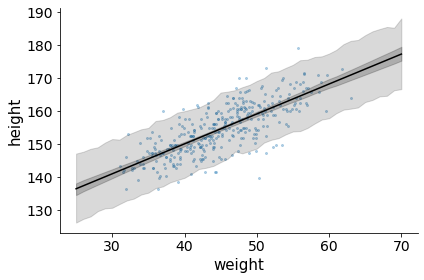

In [28]:
latexify(3, fig_height=1.4)
# define sequence of weights to compute predictions for
# these values will be on the horizontal axis
weight_seq = jnp.arange(start=25, stop=71, step=1)

# use predictive to compute mu
# for each sample from posterior
# and for each weight in weight_seq
mu = Predictive(m4_3.model, post, return_sites=["mu"])(random.PRNGKey(2), weight_seq, None)["mu"]
print(mu.shape)

# summarize the distribution of mu
mu_mean = jnp.mean(mu, 0)
mu_PI = jnp.percentile(mu, q=jnp.array([2.5, 97.5]), axis=0)
mu_HPDI = hpdi(mu, prob=0.95, axis=0)

# observed output
sim_height = Predictive(m4_3.model, post, return_sites=["height"])(random.PRNGKey(2), weight_seq, None)["height"]
height_PI = jnp.percentile(sim_height, q=jnp.array([2.5, 97.5]), axis=0)


# plot raw data
az.plot_pair(d2[["weight", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.3, "markersize": 4})

# draw MAP line
plt.plot(weight_seq, mu_mean, "k")

# draw HPDI region for line
plt.fill_between(weight_seq, mu_HPDI[0], mu_HPDI[1], color="k", alpha=0.2)

# draw PI region for simulated heights
plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)
plt.tight_layout()
sns.despine()

savefig("linreg_height_weight_loggauss_post.pdf")

# Polynomial regression

We will now consider the full dataset, including children. The resulting mapping from weight to height is now nonlinear.

## Data

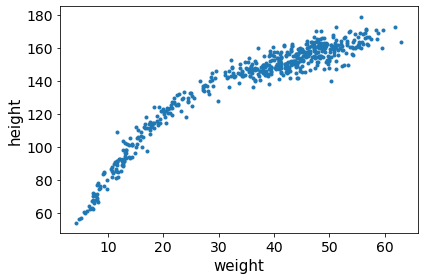

In [29]:
az.plot_pair(d[["weight", "height"]].to_dict(orient="list"))  # d, not d2
plt.tight_layout()

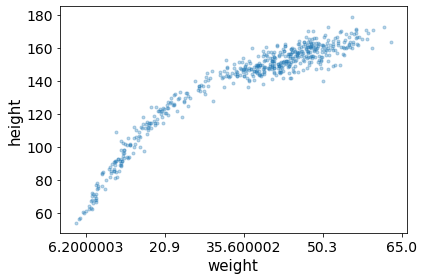

In [30]:
# standardize
d["weight_s"] = (d.weight - d.weight.mean()) / d.weight.std()

# precompute polynomial terms
d["weight_s2"] = d.weight_s**2
d["weight_s3"] = d.weight_s**3

ax = az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.3})
ax.set(xlabel="weight", ylabel="height", xticks=[])
fig = plt.gcf()

at = jnp.array([-2, -1, 0, 1, 2])
labels = at * d.weight.std() + d.weight.mean()
ax.set_xticks(at)
ax.set_xticklabels([round(label, 1) for label in labels])
# fig

plt.tight_layout()

## Fit model

In [31]:
latexify(3, fig_height=1.3)


def fit_predict(model, fname=None):
    guide = AutoLaplaceApproximation(model)
    svi = SVI(
        model,
        guide,
        optim.Adam(0.3),
        Trace_ELBO(),
        weight_s=d.weight_s.values,
        weight_s2=d.weight_s2.values,
        height=d.height.values,
    )
    params = svi.run(random.PRNGKey(0), 3000).params

    samples = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
    print_summary({k: v for k, v in samples.items() if k != "mu"}, 0.95, False)

    weight_seq = jnp.linspace(start=-2.2, stop=2, num=30)
    pred_dat = {"weight_s": weight_seq, "weight_s2": weight_seq**2}
    post = guide.sample_posterior(random.PRNGKey(1), params, (1000,))
    predictive = Predictive(guide.model, post)
    mu = predictive(random.PRNGKey(2), **pred_dat)["mu"]
    mu_mean = jnp.mean(mu, 0)
    mu_PI = jnp.percentile(mu, q=jnp.array([2.5, 97.5]), axis=0)
    sim_height = predictive(random.PRNGKey(3), **pred_dat)["height"]
    height_PI = jnp.percentile(sim_height, q=jnp.array([2.5, 97.5]), axis=0)

    ax = az.plot_pair(d[["weight_s", "height"]].to_dict(orient="list"), scatter_kwargs={"alpha": 0.3, "markersize": 4})
    plt.plot(weight_seq, mu_mean, "k")
    plt.fill_between(weight_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
    plt.fill_between(weight_seq, height_PI[0], height_PI[1], color="k", alpha=0.15)

    ax.set(xlabel="weight", ylabel="height", xticks=[])
    ax.set(xlabel="weight", ylabel="height", xticks=[])

    at = jnp.array([-2, -1, 0, 1, 2])
    labels = d.weight.mean() + at * d.weight.std()
    ax.set_xticks(at)
    labels = [round(label, 1) for label in labels]
    labels = [f"{label:.1f}" for label in labels]
    ax.set_xticklabels(labels)
    sns.despine()

    plt.tight_layout()

    if fname:
        savefig(fname)

/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Linear

100%|██████████| 3000/3000 [00:01<00:00, 1633.82it/s, init loss: 49746.6406, avg. loss [2851-3000]: 2001.7004]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
         a    138.31      0.41    138.32    137.55    139.15    931.50      1.00
        b1     25.95      0.41     25.94     25.19     26.75   1101.82      1.00
     sigma      9.36      0.29      9.36      8.84      9.99    949.32      1.00



/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


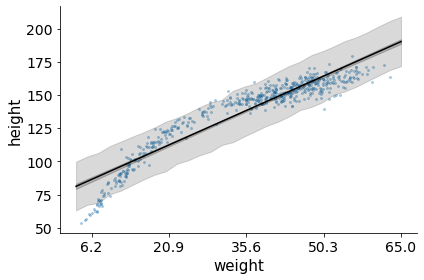

In [32]:
def model_linear(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))  # Log-Normal prior
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


fit_predict(model_linear, "linreg_height_weight_data_full_linear.pdf")

## Quadratic 

In [33]:
def model_quad(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    b2 = numpyro.sample("b2", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


fit_predict(model_quad, "linreg_height_weight_data_full_quad.pdf")

  0%|          | 0/3000 [00:00<?, ?it/s]


KeyboardInterrupt: 

100%|██████████| 3000/3000 [00:01<00:00, 1605.77it/s, init loss: 66975.6406, avg. loss [2851-3000]: 2008.9690]



                mean       std    median      2.5%     97.5%     n_eff     r_hat
         a    138.21      0.40    138.19    137.42    138.93   1049.96      1.00
        b1     26.00      0.41     26.00     25.22     26.81    824.23      1.00
        b2      0.08      0.04      0.07      0.02      0.16    935.60      1.00
     sigma      9.40      0.28      9.40      8.83      9.91    947.68      1.00



/home/shobro/anaconda3/lib/python3.7/site-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


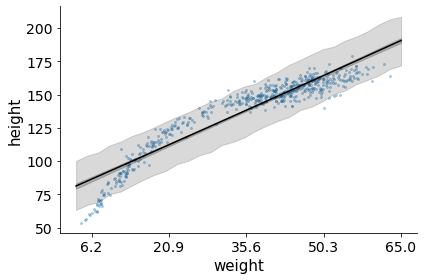

In [ ]:
def model_quad_positive_b2(weight_s, weight_s2, height=None):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b1 = numpyro.sample("b1", dist.LogNormal(0, 1))
    # b2 = numpyro.sample("b2", dist.Normal(0, 1))
    b2 = numpyro.sample("b2", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b1 * weight_s + b2 * weight_s2)
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


fit_predict(model_quad_positive_b2, "linreg_height_weight_data_full_quad_pos_b2.pdf")